In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, DepthwiseConv2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import os
import random
import shutil
import sys
import random
from tensorflow.keras import regularizers
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

train_path = '/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Final_Dataset/Train_8000/'
val_path = '/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Final_Dataset/Val_2000/'
test_path = '/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Final_Dataset/Test_3000/'
batch_size = 32
img_height = 254
img_width = 254
no_of_classes = 2
classes_name = [0,1]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip = False,
    vertical_flip = False,)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')



print(train_generator.class_indices)

Found 8617 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
{'Fire': 0, 'No_Fire': 1}


In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:
def make_model_keras(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(32, 7, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same",)(x)

    previous_block_activation = x

    for size in [16]:
        x = layers.Conv2D(size, 1, strides=1, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same",use_bias=False)(previous_block_activation)
        residual = layers.BatchNormalization()(residual)

        x = layers.add([x, residual])
        x = layers.Activation("relu")(x)


    x = layers.Conv2D(16, 3, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = 2

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [ ]:
model = make_model_keras(input_shape=(254,254,3), num_classes=2)

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
model.summary()

Model: "model_fire"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 254, 254, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 127, 127, 32  4704        ['sequential_1[0][0]']           
                                )                                                                 
                                                                                         

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Xception_v1.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
 model_history = model.fit(train_generator,epochs=25,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/25
270/270 [==============================] - ETA: 0s - loss: 0.5251 - accuracy: 0.7522 
Epoch 1: val_accuracy improved from -inf to 0.61650, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Xception_v1.h5
270/270 [==============================] - 5027s 19s/step - loss: 0.5251 - accuracy: 0.7522 - val_loss: 0.5814 - val_accuracy: 0.6165
Epoch 2/25
270/270 [==============================] - ETA: 0s - loss: 0.3966 - accuracy: 0.8417
Epoch 2: val_accuracy did not improve from 0.61650
270/270 [==============================] - 140s 517ms/step - loss: 0.3966 - accuracy: 0.8417 - val_loss: 1.1797 - val_accuracy: 0.5920
Epoch 3/25
270/270 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.8725
Epoch 3: val_accuracy did not improve from 0.61650
270/270 [==============================] - 140s 519ms/step - loss: 0.3333 - accuracy: 0.8725 - val_loss: 2.7185 - val_accuracy: 0.4920
Epoch 4/25
270/270 [===============

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:

def make_model_keras(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(16, 3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.DepthwiseConv2D(3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.DepthwiseConv2D(3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.DepthwiseConv2D(3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.DepthwiseConv2D(3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.DepthwiseConv2D(3, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(16, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = 2

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [ ]:
model = make_model_keras(input_shape=(254,254,3), num_classes=2)

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
model.summary()

Model: "model_fire"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 254, 254, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 254, 254, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 127, 127, 16)      432       
                                                                 
 batch_normalization_54 (Bat  (None, 127, 127, 16)     64        
 chNormalization)                                                
                                                                 
 activation_40 (Activation)  (None, 127, 127, 16)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 127, 127, 32)      512       
                                                        

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/MobileNet_v1.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
 model_history = model.fit(train_generator,epochs=25,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/25
270/270 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6429
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/MobileNet_v1.h5
270/270 [==============================] - 127s 461ms/step - loss: 0.6244 - accuracy: 0.6429 - val_loss: 1.3103 - val_accuracy: 0.5000
Epoch 2/25
270/270 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8412
Epoch 2: val_accuracy improved from 0.50000 to 0.65150, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/MobileNet_v1.h5
270/270 [==============================] - 123s 456ms/step - loss: 0.3811 - accuracy: 0.8412 - val_loss: 0.9943 - val_accuracy: 0.6515
Epoch 3/25
270/270 [==============================] - ETA: 0s - loss: 0.3156 - accuracy: 0.8741
Epoch 3: val_accuracy did not improve from 0.65150
270/270 [==============================] - 122

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:
# Finally Proposed model
def make_model_keras(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(8, 7, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same",)(x)

    previous_block_activation = x

    for size in [16]:
        x = layers.Conv2D(size, 1, strides=1, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same",use_bias=False)(previous_block_activation)
        residual = layers.BatchNormalization()(residual)

        x = layers.add([x, residual])
        x = layers.Activation("relu")(x)


    x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = 2

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [ ]:
model = make_model_keras(input_shape=(254,254,3), num_classes=2)

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
model.summary()

Model: "model_fire"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 254, 254, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 127, 127, 8)  1176        ['sequential_2[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 127, 127, 8)  32         ['conv2d_8[0][0]']      

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Test_1.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
model_history = model.fit(train_generator,epochs=20,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/20
270/270 [==============================] - ETA: 0s - loss: 0.5572 - accuracy: 0.7089
Epoch 1: val_accuracy improved from -inf to 0.85450, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Test_1.h5
270/270 [==============================] - 112s 407ms/step - loss: 0.5572 - accuracy: 0.7089 - val_loss: 0.4677 - val_accuracy: 0.8545
Epoch 2/20
270/270 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8271
Epoch 2: val_accuracy improved from 0.85450 to 0.86450, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Test_1.h5
270/270 [==============================] - 110s 405ms/step - loss: 0.4061 - accuracy: 0.8271 - val_loss: 0.4349 - val_accuracy: 0.8645
Epoch 3/20
270/270 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8700
Epoch 3: val_accuracy improved from 0.86450 to 0.92100, saving model to /content/drive/MyDrive/Project_Resour

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.10),
        ]
    )

In [ ]:
def make_model_keras(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(8, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [8]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)

        x = layers.add([x, residual])
        previous_block_activation = x
    x = layers.SeparableConv2D(8, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [ ]:
model = make_model_keras(input_shape=(254,254,3), num_classes=2)

In [ ]:
model.summary()

Model: "model_fire"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 254, 254, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 127, 127, 8)  224         ['sequential_1[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 127, 127, 8)  32         ['conv2d_8[0][0]']      

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Base_Paper_Model.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
model_history = model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/50
270/270 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.5792
Epoch 1: val_accuracy improved from -inf to 0.50850, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Base_Paper_Model.h5
270/270 [==============================] - 39s 139ms/step - loss: 0.6767 - accuracy: 0.5792 - val_loss: 0.6480 - val_accuracy: 0.5085
Epoch 2/50
270/270 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6380
Epoch 2: val_accuracy improved from 0.50850 to 0.57250, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Base_Paper_Model.h5
270/270 [==============================] - 37s 136ms/step - loss: 0.6273 - accuracy: 0.6380 - val_loss: 0.7592 - val_accuracy: 0.5725
Epoch 3/50
270/270 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.6836
Epoch 3: val_accuracy did not improve from 0.57250
270/270 [==============================]

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:
def Resnet_transfer_orig():
  base_model_res = tf.keras.applications.ResNet50(weights = None , include_top = False , input_shape=(254,254,3))
  x = base_model_res.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)
  pred = tf.keras.layers.Dense(no_of_classes, activation='softmax')(x)
  model = tf.keras.models.Model(inputs = base_model_res.input , outputs = pred)
  for layer in model.layers[0:]:
    layer.trainable = True
  return model

In [ ]:
model =  Resnet_transfer_orig()

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 260, 260, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 127, 127, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/ResNet_50.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
 model_history = model.fit(train_generator,epochs=25,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/25
270/270 [==============================] - ETA: 0s - loss: 0.3144 - accuracy: 0.8822
Epoch 1: val_accuracy improved from -inf to 0.54550, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/ResNet_50.h5
270/270 [==============================] - 136s 493ms/step - loss: 0.3144 - accuracy: 0.8822 - val_loss: 1.1238 - val_accuracy: 0.5455
Epoch 2/25
270/270 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9565
Epoch 2: val_accuracy improved from 0.54550 to 0.65000, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/ResNet_50.h5
270/270 [==============================] - 128s 475ms/step - loss: 0.1213 - accuracy: 0.9565 - val_loss: 5.7771 - val_accuracy: 0.6500
Epoch 3/25
270/270 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9712
Epoch 3: val_accuracy did not improve from 0.65000
270/270 [==============================] - 124s 460m

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:
def Resnet_transfer_orig():
  base_model_res = tf.keras.applications.efficientnet.EfficientNetB3(weights = None , include_top = False , input_shape=(254,254,3))
  x = base_model_res.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.4)(x)
  pred = tf.keras.layers.Dense(no_of_classes, activation='softmax')(x)
  model = tf.keras.models.Model(inputs = base_model_res.input , outputs = pred)
  for layer in model.layers[0:]:
    layer.trainable = True
  return model

In [ ]:
model =  Resnet_transfer_orig()

In [ ]:
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 254, 254, 3)  0           ['input_38[0][0]']               
                                                                                                  
 normalization (Normalization)  (None, 254, 254, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 255, 255, 3)  0           ['normalization[0][0]']    

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Efficient_Net_B3.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )

In [ ]:
model_history = model.fit(train_generator,epochs=25,validation_data=validation_generator,callbacks = [mcp_save])

Epoch 1/25
270/270 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8415
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Efficient_Net_B3.h5
270/270 [==============================] - 237s 825ms/step - loss: 0.3579 - accuracy: 0.8415 - val_loss: 2.3033 - val_accuracy: 0.5000
Epoch 2/25
270/270 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9546
Epoch 2: val_accuracy did not improve from 0.50000
270/270 [==============================] - 215s 798ms/step - loss: 0.1253 - accuracy: 0.9546 - val_loss: 5.0349 - val_accuracy: 0.5000
Epoch 3/25
270/270 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9745
Epoch 3: val_accuracy improved from 0.50000 to 0.79500, saving model to /content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Efficient_Net_B3.h5
270/270 [=============================

94/94 [==============================] - 1865s 20s/step


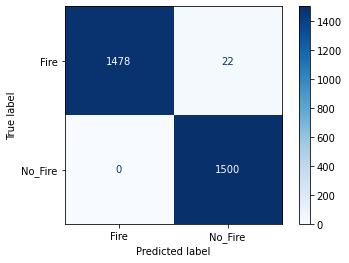

Classification Report
              precision    recall  f1-score   support

        Fire       1.00      0.99      0.99      1500
     No_Fire       0.99      1.00      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v1.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

94/94 [==============================] - 16s 165ms/step


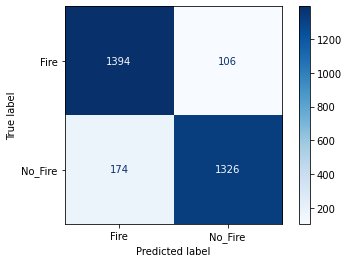

Classification Report
              precision    recall  f1-score   support

        Fire       0.89      0.93      0.91      1500
     No_Fire       0.93      0.88      0.90      1500

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v3.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

94/94 [==============================] - 15s 160ms/step


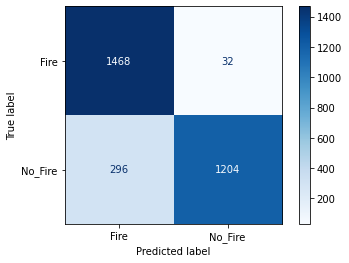

Classification Report
              precision    recall  f1-score   support

        Fire       0.83      0.98      0.90      1500
     No_Fire       0.97      0.80      0.88      1500

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/MobileNet_v2(compressed).h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

94/94 [==============================] - 16s 172ms/step


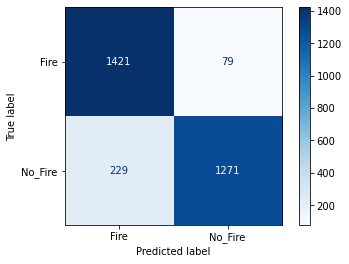

Classification Report
              precision    recall  f1-score   support

        Fire       0.86      0.95      0.90      1500
     No_Fire       0.94      0.85      0.89      1500

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Base_Paper_Model.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

94/94 [==============================] - 168s 2s/step


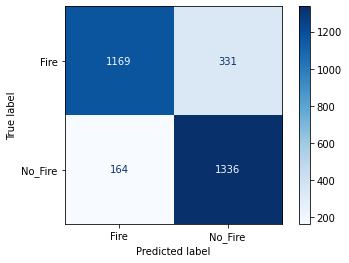

Classification Report
              precision    recall  f1-score   support

        Fire       0.88      0.78      0.83      1500
     No_Fire       0.80      0.89      0.84      1500

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/ResNet_50.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

94/94 [==============================] - 145s 2s/step


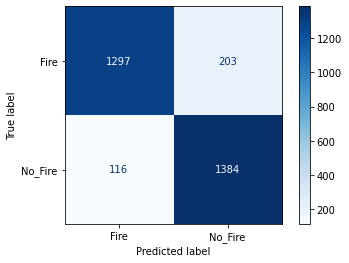

Classification Report
              precision    recall  f1-score   support

        Fire       0.92      0.86      0.89      1500
     No_Fire       0.87      0.92      0.90      1500

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Efficient_Net_B3.h5')
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(test_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 1228s 20s/step


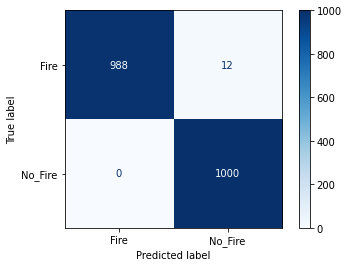

Classification Report
              precision    recall  f1-score   support

        Fire       1.00      0.99      0.99      1000
     No_Fire       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v1.h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 11s 175ms/step


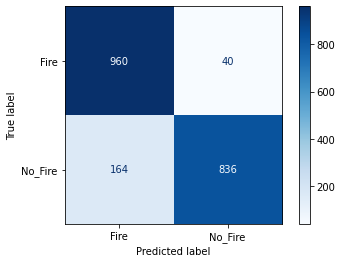

Classification Report
              precision    recall  f1-score   support

        Fire       0.85      0.96      0.90      1000
     No_Fire       0.95      0.84      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v2.h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 10s 157ms/step


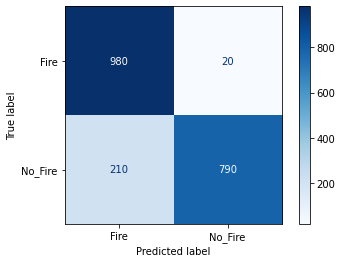

Classification Report
              precision    recall  f1-score   support

        Fire       0.82      0.98      0.89      1000
     No_Fire       0.98      0.79      0.87      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.88      2000
weighted avg       0.90      0.89      0.88      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/MobileNet_v2(compressed).h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 11s 166ms/step


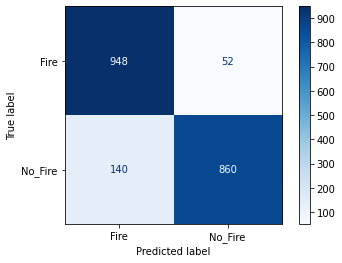

Classification Report
              precision    recall  f1-score   support

        Fire       0.87      0.95      0.91      1000
     No_Fire       0.94      0.86      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Base_Paper_Model.h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 111s 2s/step


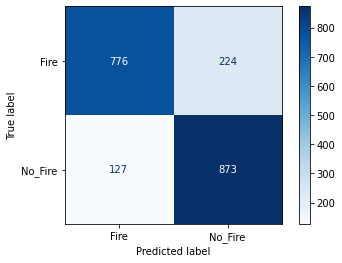

Classification Report
              precision    recall  f1-score   support

        Fire       0.86      0.78      0.82      1000
     No_Fire       0.80      0.87      0.83      1000

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/ResNet_50.h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

63/63 [==============================] - 94s 1s/step


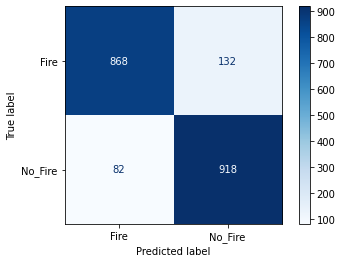

Classification Report
              precision    recall  f1-score   support

        Fire       0.91      0.87      0.89      1000
     No_Fire       0.87      0.92      0.90      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Efficient_Net_B3.h5')
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm=(confusion_matrix(validation_generator.classes, y_pred))
labels = ['Fire', 'No_Fire']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=labels))

In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v3.h5')

In [ ]:
model.summary()

Model: "model_fire"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 254, 254, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 127, 127, 8)  1176        ['sequential[0][0]']             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 127, 127, 8)  32         ['conv2d_4[0][0]']      

In [ ]:
!pip install keras_flops

In [ ]:

from keras_flops import get_flops
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v3.h5')
flops = get_flops(model,batch_size=1)
print(f"Flops:{flops/10**9:.03}G")

Flops:0.0489G


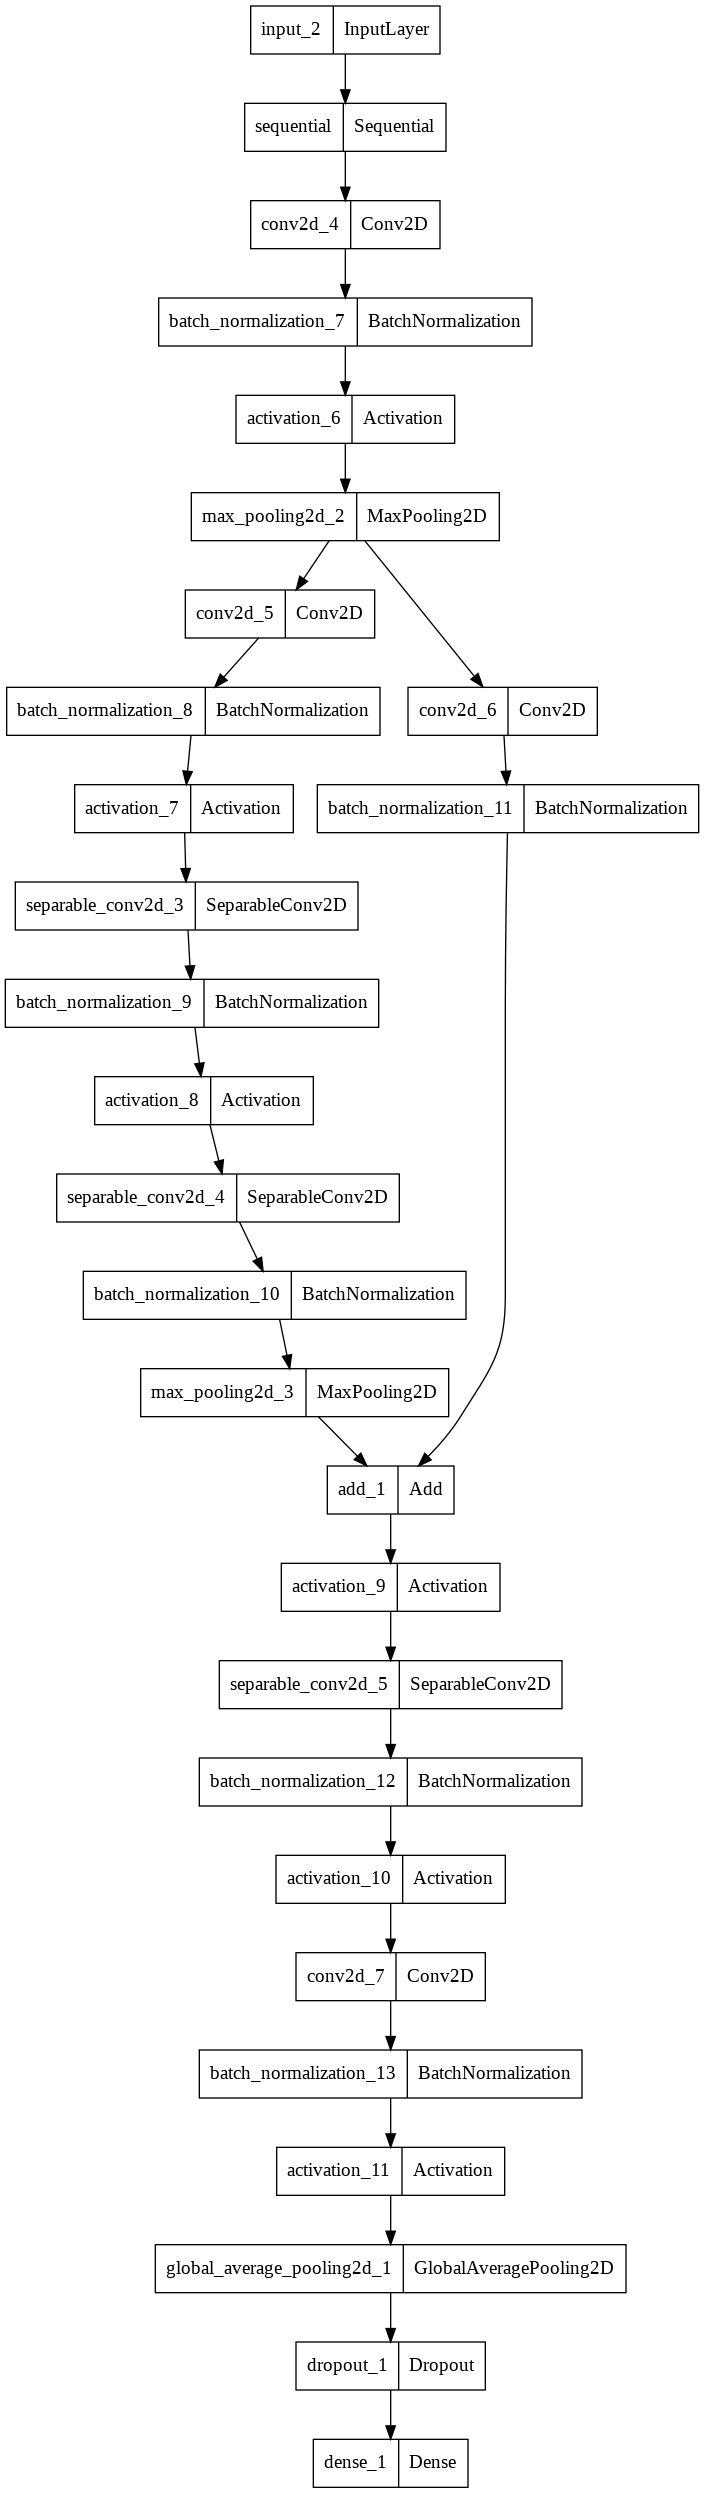

In [ ]:
model=load_model('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Proposed_v3.h5')
tf.keras.utils.plot_model(model)

In [ ]:
import keras.backend as K
def weighted_bce(y_true, y_pred):
  weights = (y_true * 59.) + 1.
  bce = K.binary_crossentropy(y_true, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce

In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.experimental.preprocessing.RandomFlip("horizontal"),
            layers.experimental.preprocessing.RandomRotation(0.15),
        ]
    )

In [ ]:
def make_model_keras(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.Conv2D(8, 7, strides=2, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same",)(x)

    previous_block_activation = x

    for size in [16]:
        x = layers.Conv2D(size, 1, strides=1, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same",use_bias=False)(previous_block_activation)
        residual = layers.BatchNormalization()(residual)

        x = layers.add([x, residual])
        x = layers.Activation("relu")(x)


    x = layers.SeparableConv2D(size, 3, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 1, strides=1, padding="same",use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = 2

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs, name="model_fire")

In [ ]:
model = make_model_keras(input_shape=(254,254,3), num_classes=2)

In [ ]:
 for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer= regularizers.l2(0.02)
        layer.kernel_regularizer= regularizers.l1(0.02)

In [ ]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project_Resources/hakathon_classification_data/Proposed_Models/Test_1.h5',monitor = 'val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
model.compile(optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics=["accuracy"] )